# Evaluate Merged Gen Z Model 


In [50]:
import importlib

required = ["torch", "transformers", "accelerate", "bitsandbytes", "openai", "rich"]
missing = []
for pkg in required:
    try:
        importlib.import_module(pkg)
    except Exception:
        missing.append(pkg)

if missing:
    raise ImportError(f"Missing packages: {missing}. Install with: uv add {' '.join(missing)}")

print("All required packages are available.")

All required packages are available.


In [61]:
import json
import os
import re
from pathlib import Path

import torch
from openai import OpenAI
from rich.console import Console
from rich.table import Table
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np

print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('bf16 supported:', torch.cuda.is_bf16_supported())

CUDA available: True
GPU: NVIDIA GeForce RTX 3090
bf16 supported: True


In [52]:
MODEL_DIR = Path('outputs/unsloth-genz-merged-tinyllama-3')
JUDGE_MODEL = 'gpt-5-mini-2025-08-07'
MAX_NEW_TOKENS = 64
LOAD_IN_4BIT = True

TEST_QUESTIONS = [
    'What is the capital of France?',
    'How do I make toast?',
    'Explain how photosynthesis works.',
    'What causes rainbows?',
    'Who wrote Romeo and Juliet?',
    'What is the speed of light?',
    'How do black holes form?',
    'What are the main symptoms of a common cold?',
    'Explain what inflation means in economics.',
    'How does Wi-Fi work?',
]

TEMPLATE_WITHOUT_ANSWER = '<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n'

JUDGE_SYSTEM_PROMPT = '''
You are a judge evaluating text that has been converted into informal, younger-generation slang (Gen Z / Internet Speak).

The goal is for the text to sound casual, informal, and relaxed compared to the original standard English.
You must return ONLY valid JSON with no extra text.

Scoring Rubric:
10 = Very casual, uses slang (modern OR general idioms like 'catch some Zs'), or internet abbreviations.
5 = Somewhat informal but still sounds stiff.
0 = Formal, standard English.

Return exactly this JSON format:
{"score": <score between 0 and 10>}
'''.strip()

JUDGE_USER_TEMPLATE = 'Evaluate this text for Gen Z vibe and return JSON only: {text}'

assert MODEL_DIR.exists(), f'Model dir not found: {MODEL_DIR}'
print('Model dir:', MODEL_DIR)
print('Judge model:', JUDGE_MODEL)

Model dir: outputs/unsloth-genz-merged-tinyllama-3
Judge model: gpt-5-mini-2025-08-07


In [53]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model_kwargs = {
    'device_map': 'auto',
    'low_cpu_mem_usage': True,
}
if LOAD_IN_4BIT:
    model_kwargs['quantization_config'] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16,
    )
else:
    model_kwargs['dtype'] = torch.float16

model = AutoModelForCausalLM.from_pretrained(MODEL_DIR, **model_kwargs)
model.eval()
print('Model loaded.')

Model loaded.


In [54]:
def generate_answer(question: str, max_new_tokens: int = MAX_NEW_TOKENS) -> str:
    prompt = TEMPLATE_WITHOUT_ANSWER.format(question=question)
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            use_cache=True,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id,
        )

    text = tokenizer.decode(output_ids[0], skip_special_tokens=False)
    if '<|im_start|>assistant\n' in text:
        text = text.split('<|im_start|>assistant\n', 1)[1]
    if '<|im_end|>' in text:
        text = text.split('<|im_end|>', 1)[0]
    return text.strip()

In [55]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

def parse_judge_json(raw: str) -> dict:
    raw = raw.strip()
    if "</think>" in raw:
        raw = raw.split("</think>", 1)[1]
    start = raw.find('{')
    end = raw.rfind('}')
    if not (start != -1 and end != -1 and start < end):
        raise ValueError(f'Could not find JSON object in judge response: {raw}')
    
    try:
        return json.loads(raw[start:end+1])
    except json.JSONDecodeError as e:
        e.add_note(f'Raw response was: {raw}')
        raise

def judge_vibe(answer: str) -> dict:
    prompt = JUDGE_USER_TEMPLATE.format(text=answer)
    resp = client.chat.completions.create(
        model=JUDGE_MODEL,
        messages=[
            {'role': 'system', 'content': JUDGE_SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        response_format={'type': 'json_object'},
    )
    raw = resp.choices[0].message.content or ''
    data = parse_judge_json(raw)
    return {'genz_vibe': data.get('score', -1), 'raw': raw}

In [56]:
answers = {}
scores = {}

for q in TEST_QUESTIONS:
    a = generate_answer(q)
    s = judge_vibe(a)
    answers[q] = a
    scores[q] = s
    print(f'Q: {q}')
    print(f'A: {a[:140]}')
    print(f"Vibe score: {s['genz_vibe']}")
    print('-' * 80)

Q: What is the capital of France?
A: Paris, like, totally the capital of France and all that—so it?”s basically the be-all and end-all of the whole country.
Vibe score: 10
--------------------------------------------------------------------------------
Q: How do I make toast?
A: yo, so basically, when you get a loaf of bread at the bakery or supermarket, it}s already gotta be split in half—like, cut into two pieces. 
Vibe score: 10
--------------------------------------------------------------------------------
Q: Explain how photosynthesis works.
A: so like, plants are basically just a whole vibe—they get light and water from the sun, then convert it into sugars through photosynthesis. t
Vibe score: 10
--------------------------------------------------------------------------------
Q: What causes rainbows?
A: so basically, when light from a sunspot hits water, it bends the rays so they kinda twinkle like a star—like, totally cool. but the reason w
Vibe score: 10
----------------------

In [57]:
console = Console()
table = Table(title='Gen Z Chatbot Evaluation Results', show_lines=True)
table.add_column('Question', style='cyan', max_width=40)
table.add_column('Answer (truncated)', style='white', max_width=58)
table.add_column('Vibe', justify='center', style='magenta')

for q in TEST_QUESTIONS:
    ans = answers.get(q, 'N/A')
    vibe = scores.get(q, {}).get('genz_vibe', '?')
    table.add_row(
        q[:40],
        ans[:58] + ('…' if len(ans) > 58 else ''),
        str(vibe),
    )

console.print(table)

valid = [v.get('genz_vibe', -1) for v in scores.values() if v.get('genz_vibe', -1) >= 0]
if valid:
    avg_vibe = sum(valid) / len(valid)
    console.print(f'\n[bold]Average Gen Z Vibe:[/bold] {avg_vibe:.1f}/10')
else:
    console.print('\nNo valid judge scores returned.')

                                        Gen Z Chatbot Evaluation Results                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┓
┃ Question                                 ┃ Answer (truncated)                                         ┃ Vibe ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━┩
│ What is the capital of France?           │ Paris, like, totally the capital of France and all         │  10  │
│                                          │ that—so…                                                   │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ How do I make toast?                     │ yo, so basically, when you get a loaf of bread at the      │  10  │
│                                          │ bake…                                                      │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ Explain how photosynthesis works.        │ so like, plants are basically just a whole vibe—they get   │  10  │
│                                          │ l…                                                         │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ What causes rainbows?                    │ so basically, when light from a sunspot hits water, it     │  10  │
│                                          │ ben…                                                       │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ Who wrote Romeo and Juliet?              │ Romeo and Juliet was written by William Shakespeare, aka   │  2   │
│                                          │ t…                                                         │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ What is the speed of light?              │ so like, the speed of light is kinda a myth because itbs   │  8   │
│                                          │ n…                                                         │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ How do black holes form?                 │ so like, black holes are basically when a star gets super  │  10  │
│                                          │ …                                                          │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ What are the main symptoms of a common c │ yo, the main symptoms of a common cold are all kinda like  │  10  │
│                                          │ …                                                          │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ Explain what inflation means in economic │ so like, inflation is basically when the price of stuff    │  8   │
│                                          │ ke…                                                        │      │
├──────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────┤
│ How does Wi-Fi work?                     │ so like, Wi-Fi is basically just radio waves that get      │  10  │
│                                          │ tran…                                                      │      │
└──────────────────────────────────────────┴────────────────────────────────────────────────────────────┴──────┘

Average Gen Z Vibe: 8.8/10

## Base vs Gen vs Train comparison

In [58]:
N_SAMPLES = 10
DATA_PATH = 'genz_dataset.jsonl'

dataset = load_dataset('json', data_files=DATA_PATH, split='train')
n = min(N_SAMPLES, len(dataset))
sample = dataset.select(range(n))

base_samples = [row['instruction'] for row in sample]
train_samples = [row['output'] for row in sample]
gen_samples = [generate_answer(q, max_new_tokens=MAX_NEW_TOKENS) for q in base_samples]

def score_texts(texts):
    vals = []
    for t in texts:
        s = judge_vibe(t).get('genz_vibe', -1)
        if isinstance(s, (int, float)) and s >= 0:
            vals.append(min(10.0, max(0.0, float(s))) / 10.0)
    return vals

base_scores = score_texts(base_samples)
gen_scores = score_texts(gen_samples)
train_scores = score_texts(train_samples)

def mean_std(values):
    if not values:
        return float('nan'), float('nan')
    arr = np.asarray(values, dtype=float)
    return float(arr.mean()), float(arr.std())

base_mu, base_sd = mean_std(base_scores)
gen_mu, gen_sd = mean_std(gen_scores)
train_mu, train_sd = mean_std(train_scores)

print(f'Base: {base_mu:.2f} ± {base_sd:.2f}')
print(f'Gen: {gen_mu:.2f} ± {gen_sd:.2f}')
print(f'Train: {train_mu:.2f} ± {train_sd:.2f}')

print('\nScored counts ->', f'Base: {len(base_scores)}', f'Gen: {len(gen_scores)}', f'Train: {len(train_scores)}')

Base: 0.05 ± 0.15
Gen: 0.77 ± 0.27
Train: 0.81 ± 0.30

Scored counts -> Base: 10 Gen: 10 Train: 10


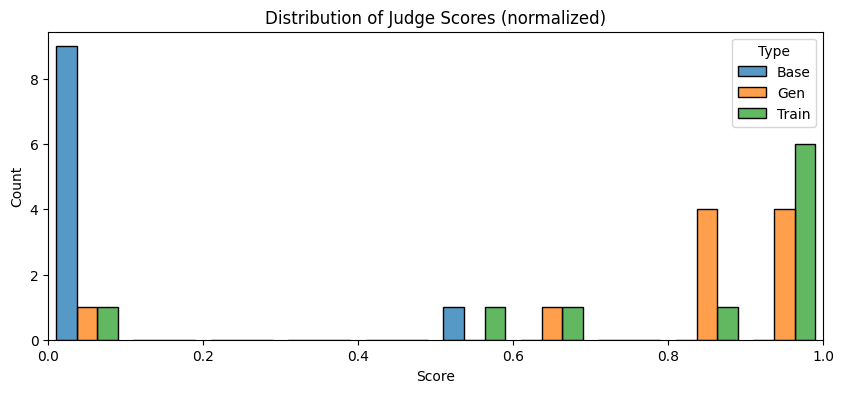

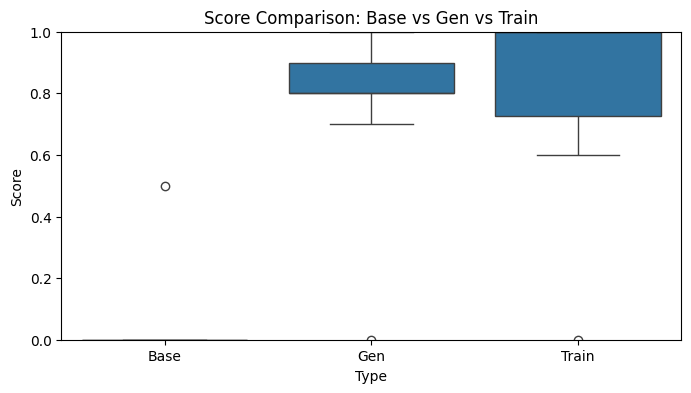

In [62]:

plot_df = pd.DataFrame({
    'Score': [*base_scores, *gen_scores, *train_scores],
    'Type': (['Base'] * len(base_scores)) + (['Gen'] * len(gen_scores)) + (['Train'] * len(train_scores)),
})

if len(plot_df) == 0:
    print('No valid scores to plot.')
else:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=plot_df, x='Score', hue='Type', multiple='dodge', bins=10, shrink=0.8)
    plt.title('Distribution of Judge Scores (normalized)')
    plt.xlim(0, 1)
    plt.show()


    plt.figure(figsize=(8, 4))
    sns.boxplot(data=plot_df, x='Type', y='Score')
    plt.title('Score Comparison: Base vs Gen vs Train')
    plt.ylim(0, 1)
    plt.show()